# DM-29347: slot_shape flag on negative sources

### The slot shape flag does a good job of finding junk sources but unfortunately flags all negative flux sources even if they are otherwise OK. Investigate what happens when we switch to HSM shape.

In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd
import gc

from astropy.coordinates import SkyCoord
import astropy.units as u
from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize, LinearStretch)

import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
afwDisplay.setDefaultBackend('matplotlib')
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct


import IPython
from IPython.display import IFrame, Image

from lsst.analysis.ap import legacyApdbUtils as lau
from lsst.analysis.ap import legacyCoaddAnalysis as lca
from lsst.analysis.ap import legacyPlotUtils as lpu

from lsst.analysis.ap import zooniverseCutouts

In [2]:
repo = '/sdf/group/rubin/u/parejko/cosmos-DM-36199/repo'
repo2='/sdf/group/rubin/u/parejko/scratch/ap_verify_runs/cosmos-hsmShape/repo'
butler = dafButler.Butler(repo, collections='ap_verify-output')
butler2 = dafButler.Butler(repo2, collections='ap_verify-output')

Run with the default settings (SDSS shape underneath):

In [3]:
objTable, srcTable, goodObj, goodSrc = lau.loadTables(repo,
                                                         dbType='sqlite',
                                                          dbName='/sdf/group/rubin/u/parejko/cosmos-DM-36199/association.db',
                                                          instrument='HSC',
                                                      allCol=True
                                                    )

/tmp/ipykernel_2945/3511548173.py:1: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = lau.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-37432/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:250: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-37432/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:483: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rub

This run is with HSM shape:

In [4]:
objTable2, srcTable2, goodObj2, goodSrc2 = lau.loadTables(repo2,
                                                          dbType='sqlite',
                                                          dbName='/sdf/group/rubin/u/parejko/scratch/ap_verify_runs/cosmos-hsmShape/association.db',
                                                         instrument='HSC',
                                                          allCol=True
                                                        )

/tmp/ipykernel_2945/1871549440.py:1: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable2, srcTable2, goodObj2, goodSrc2 = lau.loadTables(repo2,
/sdf/group/rubin/u/kherner/DM-37432/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:250: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-37432/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:483: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/grou

In [5]:
# Old (NCSA) runs; may not work properly.

defaultshape = SimpleNamespace(collection = 'u/kherner/2.2i/runs/DM-29347_defaults',
                               apdb = '/project/kherner/DM-29347_negSources/DM-29347_default_debug.db',
                               schema = 'kherner',
                              selname = 'goodSeeing')
simpleshape = SimpleNamespace(collection = 'u/kherner/2.2i/runs/DM-29347',
                               apdb = '/project/kherner/DM-29347_negSources/DM-29347_debug.db',
                               schema = 'kherner',
                              selname = 'goodSeeing')

In [6]:
gc.collect()

56680

### Set up flag info

In [7]:

flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = lau.makeSrcTableFlags(srcTable,
                                                                                         objTable,
                                                                                         instrument='HSC',
                                                                                         repo=repo)

flagTable2, srcTableFlags2, flagFilter2, goodSrc2, goodObj2 = lau.makeSrcTableFlags(srcTable2,
                                                                                         objTable2,
                                                                                         instrument='HSC',
                                                                                         repo=repo2)


/tmp/ipykernel_2945/3599676887.py:1: FutureWarning: Call to deprecated function (or staticmethod) makeSrcTableFlags. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = lau.makeSrcTableFlags(srcTable,
/sdf/group/rubin/u/kherner/DM-37432/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:445: FutureWarning: Call to deprecated function (or staticmethod) addTableMetadata. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  addTableMetadata(sourceTable, butler=butler, instrument=instrument)
/tmp/ipykernel_2945/3599676887.py:6: FutureWarning: Call to deprecated function (or staticmethod) makeSrcTableFlags. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  flagTable2, srcTableFlags2, flagFilter2, goodSrc2, goodObj2 = lau.makeS

### Flag histogram for default runs

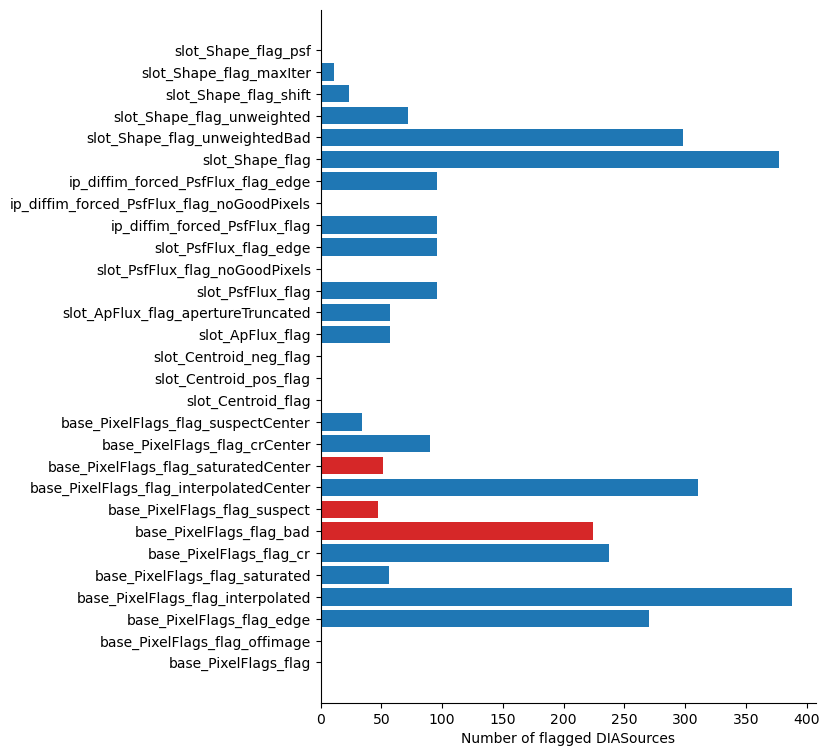

In [8]:
lpu.plotFlagHist(srcTable)

### Flag histogram for HSM shape run

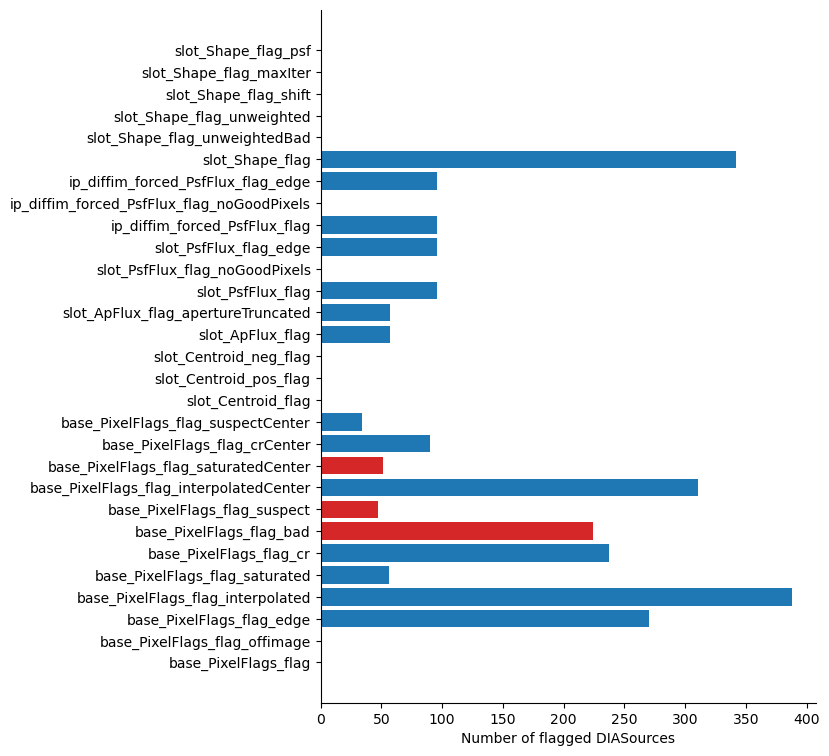

In [9]:
lpu.plotFlagHist(srcTable2)

### We immediately see that in the HSM shape case a few of the slot_shape_X flags are not available, but the overall slot_Shape_flag is. We also see that the number of sources with that flag set is smaller than in the default casem however, which is encouraging.

In [9]:
def allTables(run):
    instrument='LSSTCam-imSim'
    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    dbPath = apdb

    objTable, srcTable, goodObj, goodSrc = lau.loadTables(repo2,
                                                          dbType='sqlite',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          instrument=instrument,
                                                          allCol=True
                                                        )
#    srcTable = lau.addVisitDetectorToSrcTable(srcTable, instrument=instrument, butler=butler2)
    
 #   flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = lau.makeSrcTableFlags(srcTable, objTable,
 #                                                                                   instrument=instrument,
 #                                                                                  repo=repo2)
    
    return flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable

### Make some cutouts of negative-flux sources. Split them by slot_Shape_flag value so we can get an idea of whether those with slot_Shape_flag still set to true are in fact bad.

In [10]:
config = zooniverseCutouts.ZooniverseCutoutsConfig()
config.urlRoot = ''
zc = zooniverseCutouts.ZooniverseCutoutsTask(config)

In [11]:
sig = 5
falseSrc = goodSrc2.loc[(goodSrc2['psFlux']<0)&(goodSrc2['slot_Shape_flag']==False)&(goodSrc2['snr']>=sig)]
trueSrc = goodSrc2.loc[(goodSrc2['psFlux']<0)&(goodSrc2['slot_Shape_flag']==True)&(goodSrc2['snr']>=sig)]

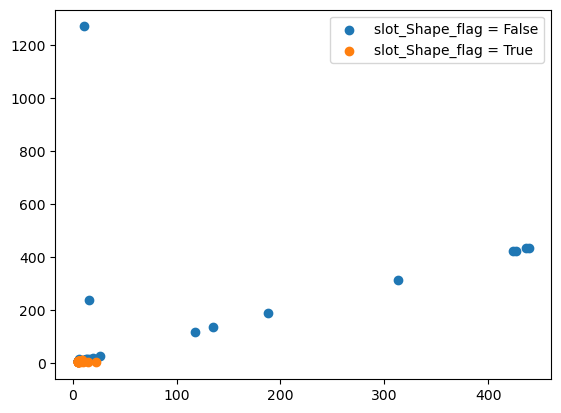

In [12]:
plt.scatter(falseSrc['snr'],abs(falseSrc['psFlux']/falseSrc['psFluxErr']),
           label='slot_Shape_flag = False')
plt.scatter(trueSrc['snr'],abs(trueSrc['psFlux']/trueSrc['psFluxErr']),
           label='slot_Shape_flag = True')
plt.legend(labels=['slot_Shape_flag = False','slot_Shape_flag = True'])

Write the cutouts to files; change the path appropriately if you're running it yourself.

In [13]:
falsearray = zc.write_images(falseSrc,
                butler2, '/sdf/group/rubin/u/kherner/DM-29347_negSources/zc_False')

In [14]:
truearray = zc.write_images(trueSrc,
                butler2, '/sdf/group/rubin/u/kherner/DM-29347_negSources/zc_True')

### Cutouts for slot_Shape_Flag = False sources

33 sources above SNR cut with slot_shape_flag = False
25404838930022783


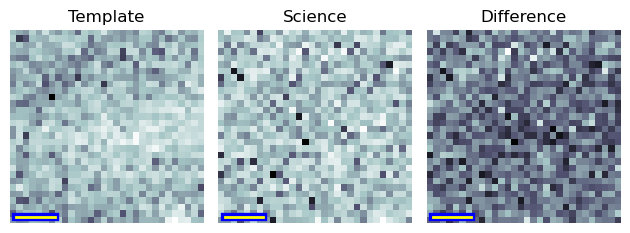

25404838930022785


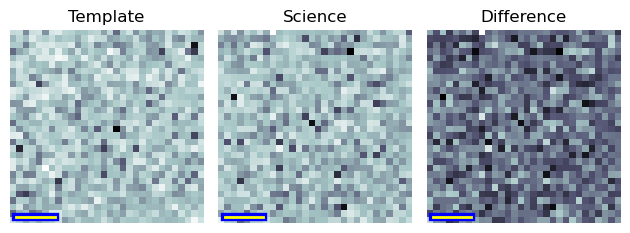

25404838930022845


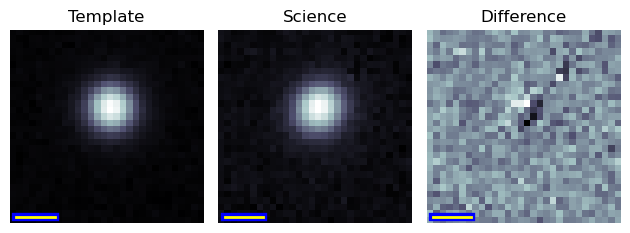

25404838930022852


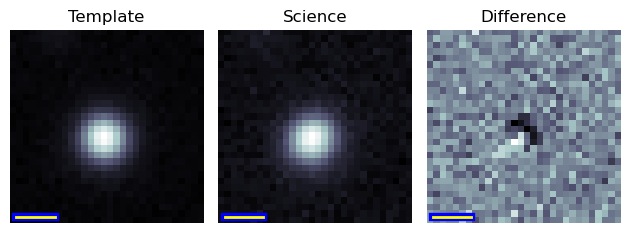

25404838930022863


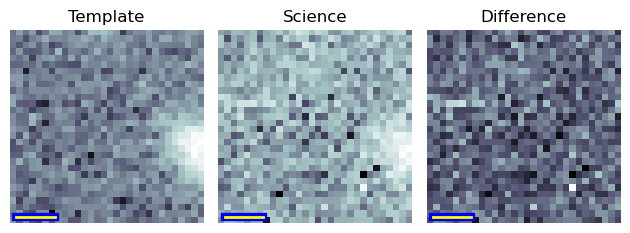

25404838930022935


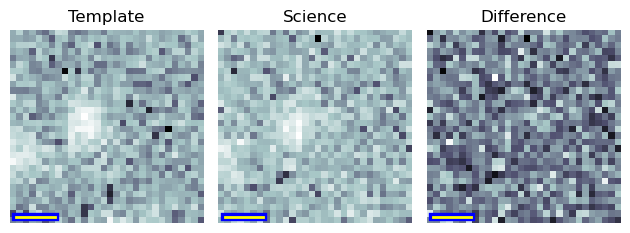

25404838930022955


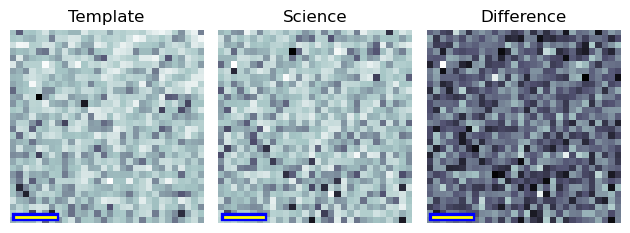

25404838930023006


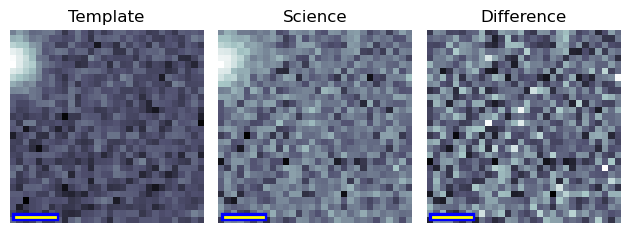

25404838930023015


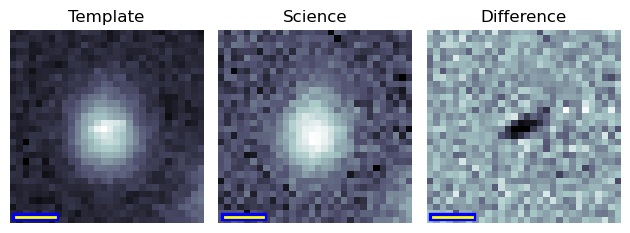

25404838930023031


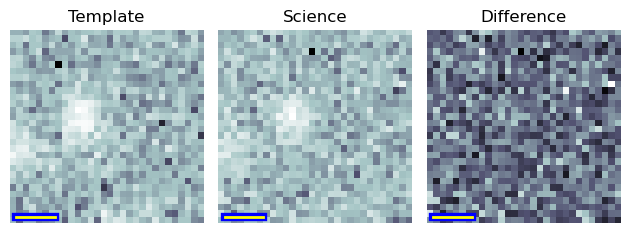

25404838930023033


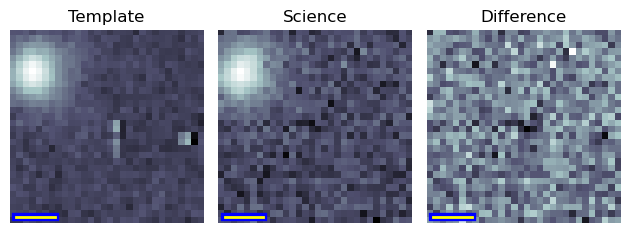

25404838930023042


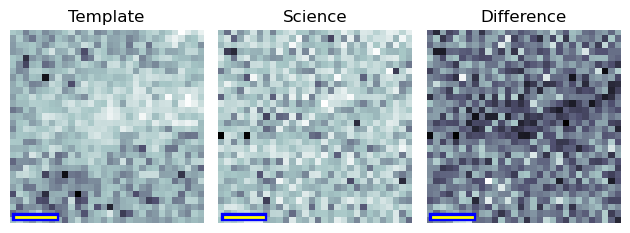

25404838930023044


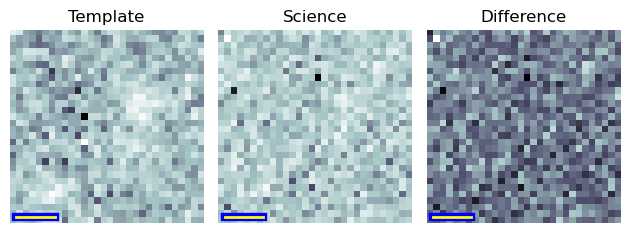

25404838930023049


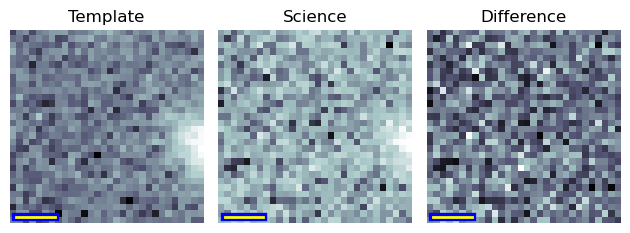

25409136044802375


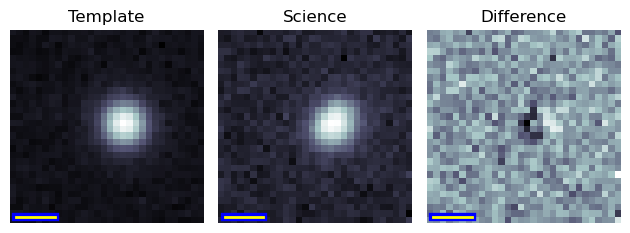

25409136044802401


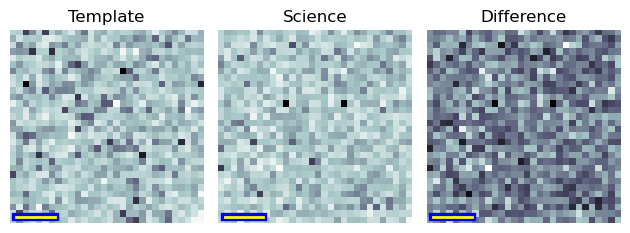

25409136044802454


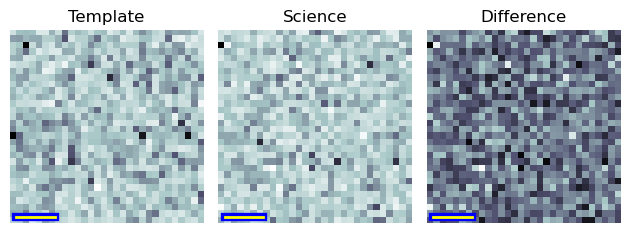

25409136044802525


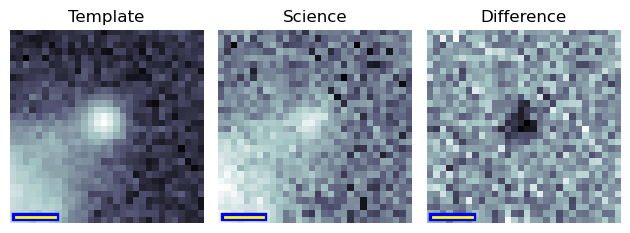

25409136044802538


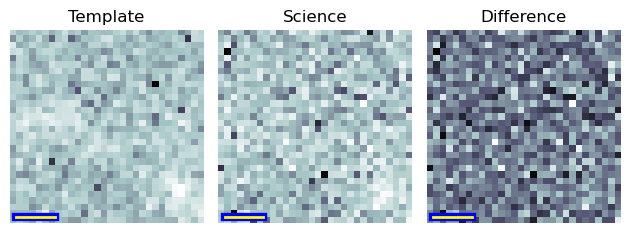

25409136044802409


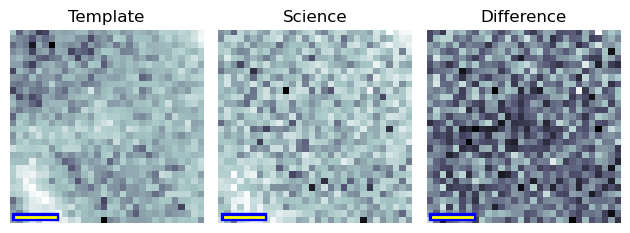

25409136044802458


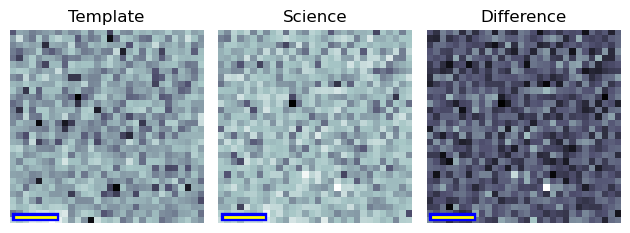

25409136044802465


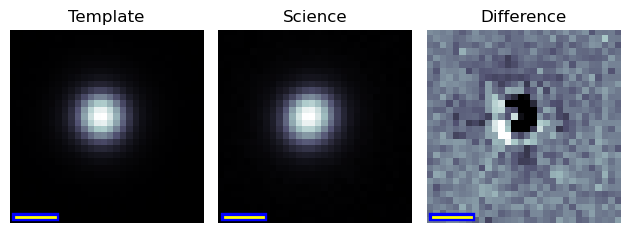

25409136044802469


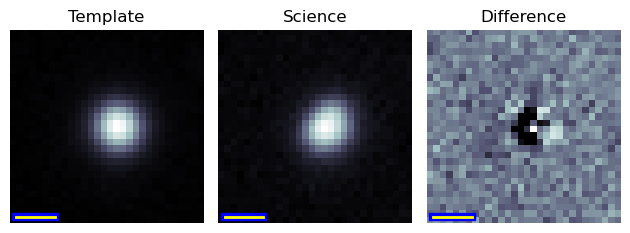

25409136044802471


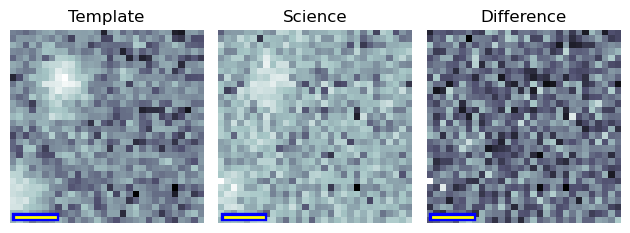

25409136044802472


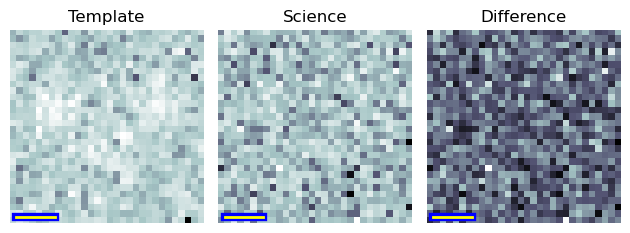

25409136044802497


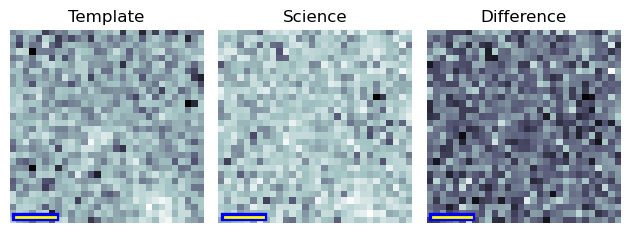

25409136044802499


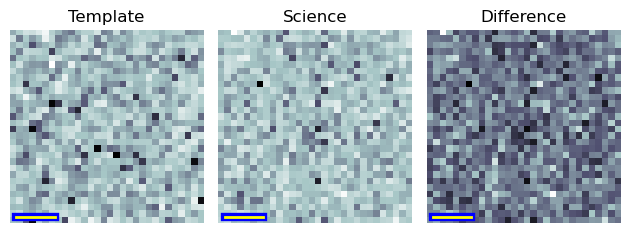

25409136044802510


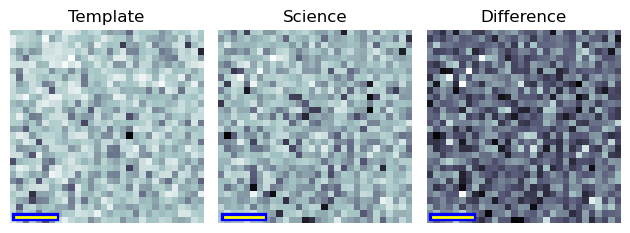

25409136044802511


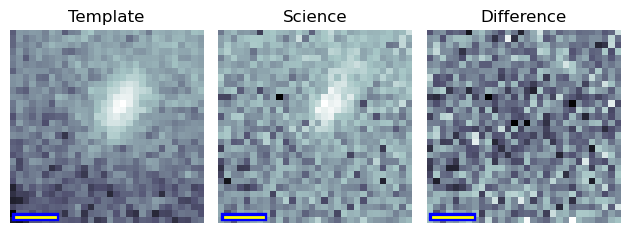

25409136044802517


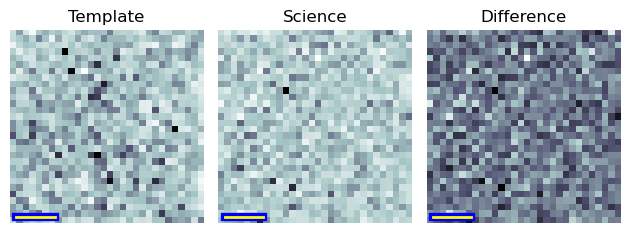

25409136044802545


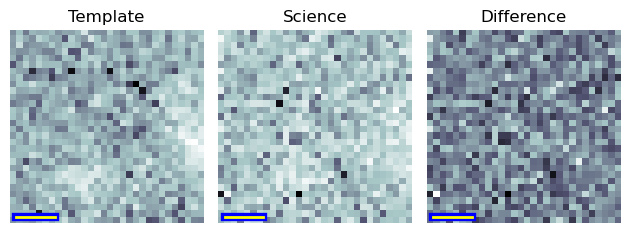

25409136044802551


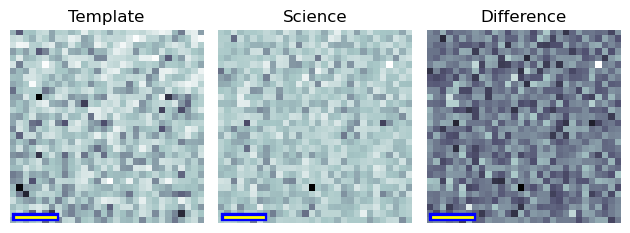

25409136044802561


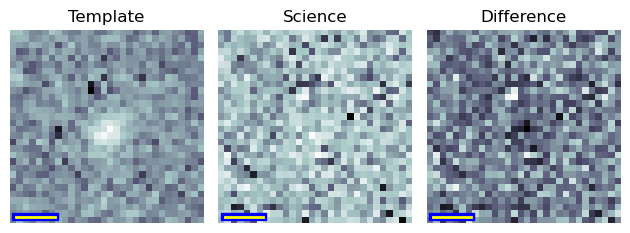

In [15]:
print(str(len(falsearray))+' sources above SNR cut with slot_shape_flag = False')
plt.figure(figsize=(10,10))
idx = 0
for myimg in glob.glob('/sdf/group/rubin/u/kherner/DM-29347_negSources/zc_False/images/*.png'):
    print(falsearray[idx])
    idx += 1
    display(Image(filename=myimg))

### Cutouts for slot_Shape_Flag = True sources

23 sources above SNR cut with slot_shape_flag = True
25404838930022797


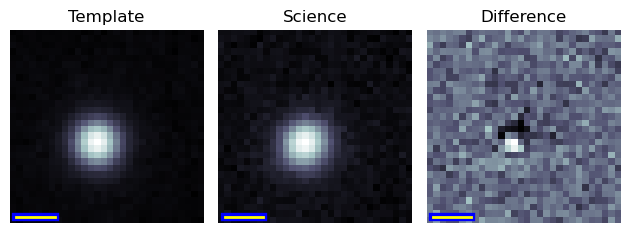

25404838930022814


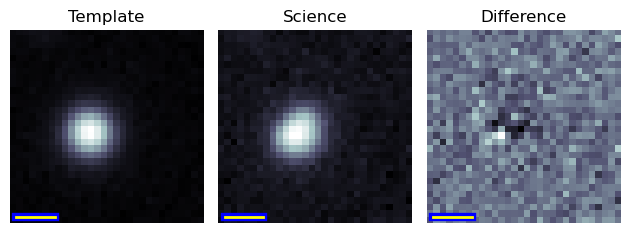

25404838930022829


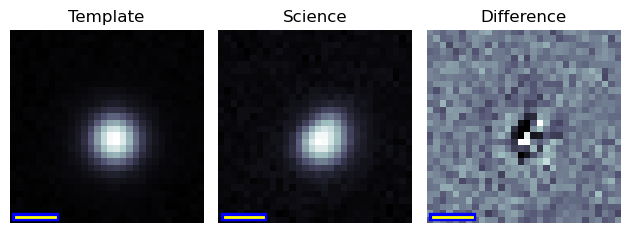

25404838930022876


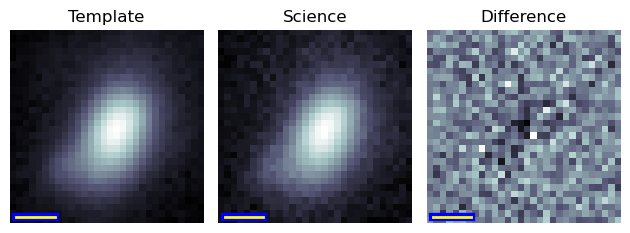

25404838930022901


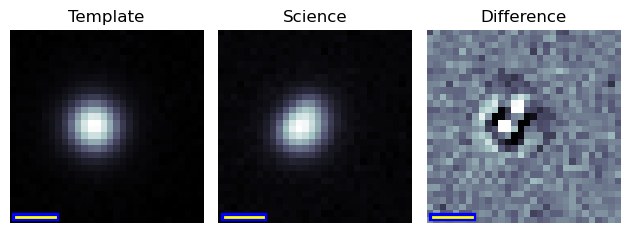

25404838930022913


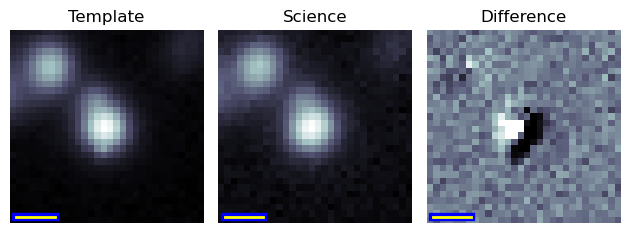

25404838930022942


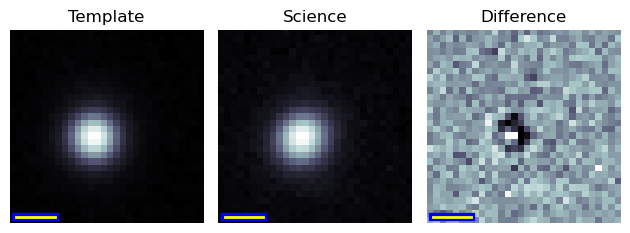

25404838930022946


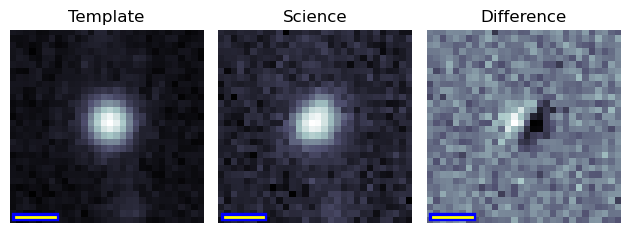

25404838930022950


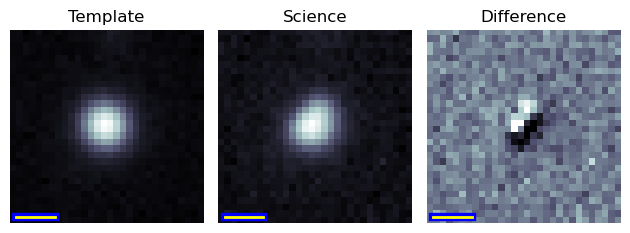

25404838930022984


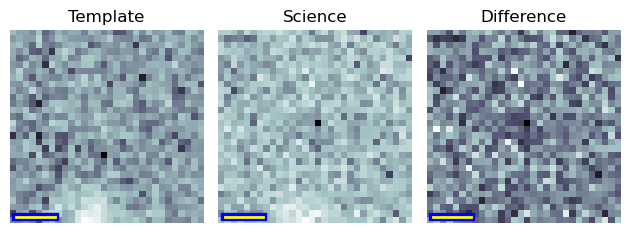

25404838930023018


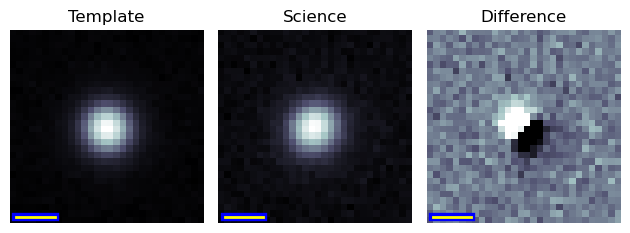

25409136044802503


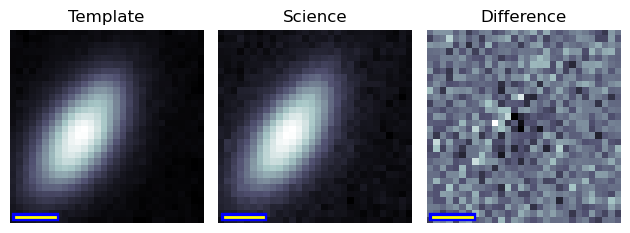

25409136044802523


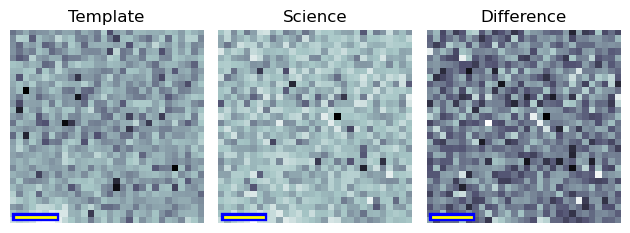

25409136044802411


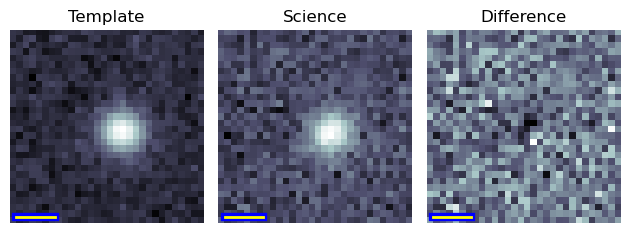

25409136044802448


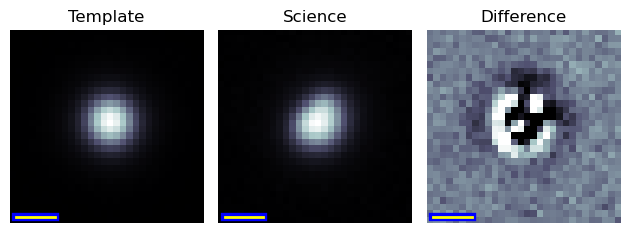

25409136044802453


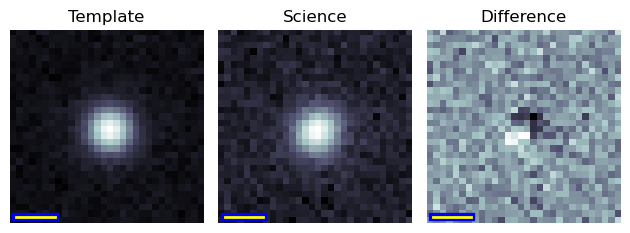

25409136044802459


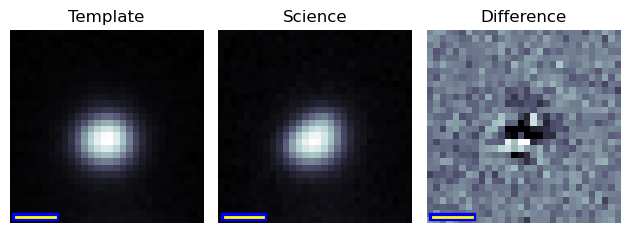

25409136044802464


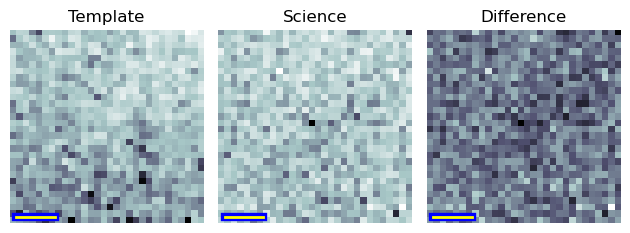

25409136044802474


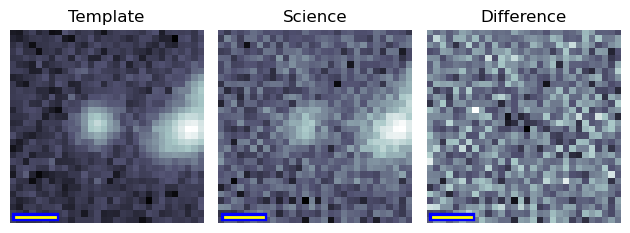

25409136044802485


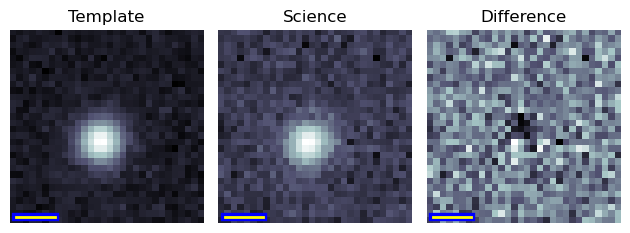

25409136044802506


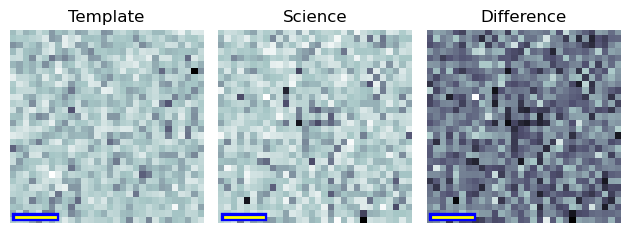

25409136044802519


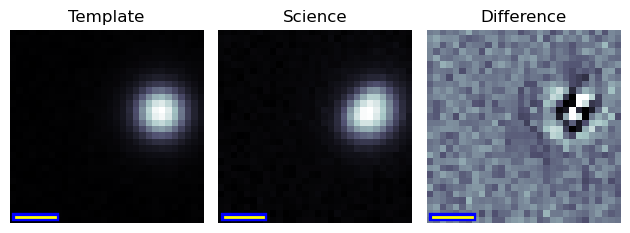

25409136044802560


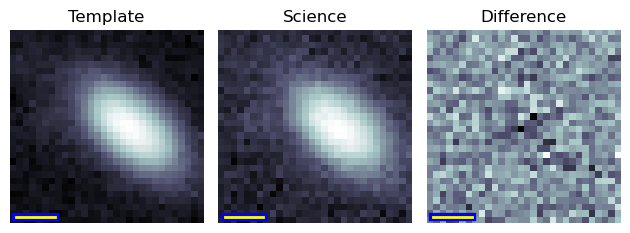

In [16]:
plt.figure(figsize=(10,10))
print(str(len(truearray))+' sources above SNR cut with slot_shape_flag = True')
idx = 0
for myimg in glob.glob('/sdf/group/rubin/u/kherner/DM-29347_negSources/zc_True/images/*.png'):
    print(truearray[idx])
    idx += 1
    display(Image(filename=myimg))

Flux/err comparison for negative flux sources, split by true and false

## Conclusions

In the ap_verify cosmos dataset we see that switching to HSM Shape no longer flags all negative sources. We recover 33/56 (59%) such sources, and visual inspection of the cutouts shows that the sources where slot_Shape_flag is still true are indeed highly suspect on average, while those where it is now false appear on average to be reasonable. It is worth strongly considering switching the AP pipeline over to HSM shape in this case (and possibly DRP as well after an RFC) as long as the lack of the other slot_Shape_X flags does not have any undesirable side effects.